Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "test_22987_suffix50_11_CNN2_differentConfig_softmax2"

from configParser import ConfigParser
params = ConfigParser(experimentName).read()
print(params)

import os
experimentName = os.path.join(experimentName, "single-trial")
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)

import dataLoader 

{'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.01, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 2, 'useAdam': False, 'resnet': '18', 'normalize': False, 'softmax': True}


Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Load images

In [4]:
import torchvision

# load images
datasetManager = dataLoader.datasetManager(experimentName, True)
datasetManager.updateParams(params)
dataset = datasetManager.getDataset()
speciesList = dataset.getSpeciesList()
numberOfSpecies = len(speciesList)
print('species:', speciesList)
print("Number of species = ", numberOfSpecies)
genusList = dataset.getGenusList()
numberOfGenus = len(genusList)
print('genus:', genusList)
print("Number of species = ", numberOfGenus)

file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_softmax2/single-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/dataset.pkl read
species: ['Lepomis cyanellus', 'Lepomis auritus', 'Carassius auratus', 'Cyprinus carpio', 'Esox americanus', 'Esox lucius', 'Noturus gyrinus', 'Noturus exilis', 'Noturus flavus', 'Noturus eleutherus', 'Noturus insignis']
Number of species =  11
genus: ['Lepomis', 'Carassius', 'Cyprinus', 'Esox', 'Noturus']
Number of species =  5


Create/Load model

In [5]:
import os

architecture = {
    "species": numberOfSpecies,
    "genus" : numberOfGenus
}
model = CNN.create_model(architecture, params)

train_loader, validation_loader, test_loader = datasetManager.getLoaders()
if os.path.exists(CNN.getModelFile(experimentName)):
    loss_list, accuracy_list, epochs, time_elapsed = CNN.loadModel(model, experimentName)
    print("Model {0} loaded!".format(experimentName))
else:
    loss_list, accuracy_list, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, params, model, experimentName)

Loading saved dataloaders...
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_softmax2/single-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/trainingLoader.pkl read
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_softmax2/single-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/valLoader.pkl read
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_softmax2/single-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/testLoader.pkl read
Model test_22987_suffix50_11_CNN2_differentConfig_softmax2/single-trial loaded!


Plot

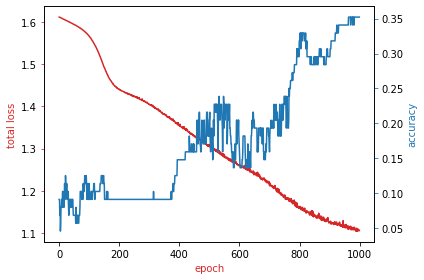

In [6]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

Create confusion matrix

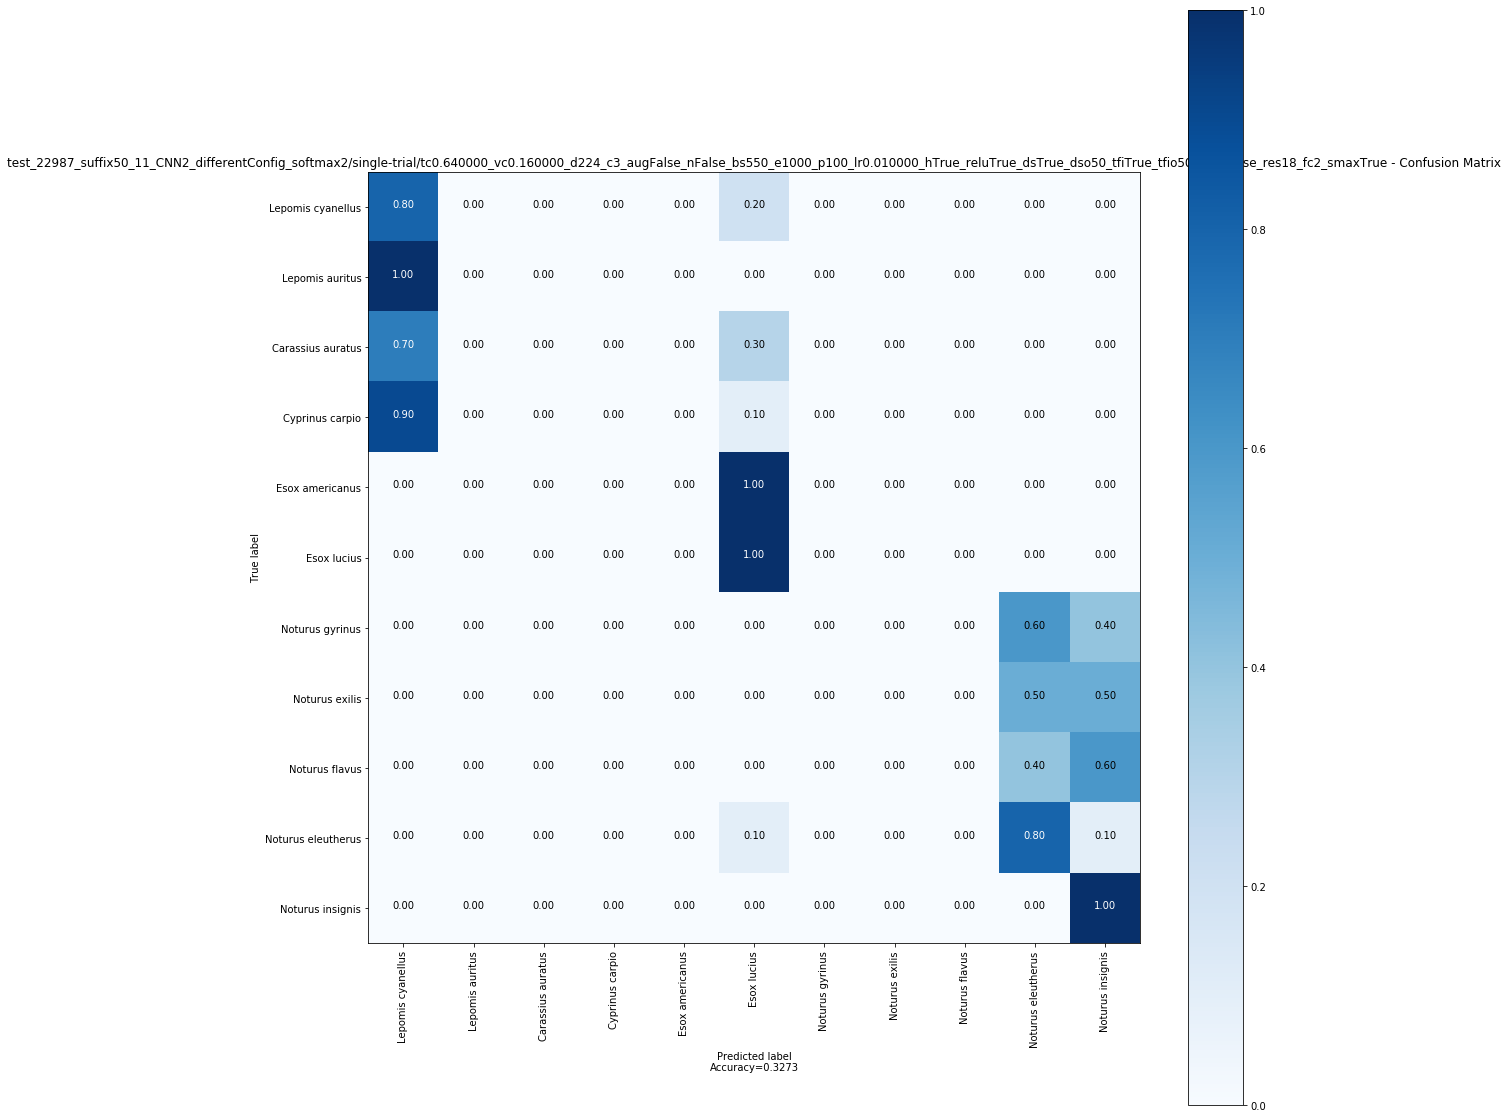

Macro f1: 0.17678008587099495


In [7]:
predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, params)
ts.addTrialPredictions(params, predlist, lbllist, numberOfSpecies)
conf_mat = ts.printTrialConfusionMatrix(params, speciesList, True)

from sklearn.metrics import f1_score
macro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')
print("Macro f1:", macro_f1)

Precision/Recall/Fscore

In [8]:
ts.addTrial(params,
            {'loss': CNN.getCrossEntropyFromLoader(test_loader, model, params),
             'accuracy': CNN.getAccuracyFromLoader(test_loader, model, params),
             'macro f1': macro_f1,
             'time': time_elapsed,
             'epochs': epochs
            })


In [9]:
ts.showStatistics()
ts.saveStatistics()

Aggregated statistics


In [10]:
ts.showStatistics(False)
ts.saveStatistics(False)

Raw statistics


,image_path,suffix,training_count,validation_count,imageDimension,n_channels,augmentation,batchSize,n_epochs,learning_rate,numOfTrials,patience,useHeirarchy,useRelu,downsample,downsampleOutput,takeFromIntermediate,takeFromIntermediateOutput,fc_layers,useAdam,resnet,normalize,softmax,loss,accuracy,macro f1,time,epochs,hash
0,/data/BGNN_data/INHS_cropped,50_11,0.64,0.16,224,3,False,550,1000,0.01,3,100,True,True,True,50,True,50,2,False,18,False,True,2.275049,0.327273,0.17678,10926.054993,1000.0,-4119650856261723092


In [11]:
ts.printF1table(params, dataset)

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.363636,0.615385,0.470588
1,1 Lepomis auritus,0 Lepomis,0.000000,0.000000,0.000000
2,2 Carassius auratus,1 Carassius,0.000000,0.000000,0.000000
3,3 Cyprinus carpio,2 Cyprinus,0.000000,0.000000,0.000000
4,4 Esox americanus,3 Esox,0.000000,0.000000,0.000000
5,5 Esox lucius,3 Esox,0.540541,0.666667,0.740741
6,6 Noturus gyrinus,4 Noturus,0.000000,0.000000,0.000000
7,7 Noturus exilis,4 Noturus,0.000000,0.000000,0.000000
8,8 Noturus flavus,4 Noturus,0.000000,0.000000,0.000000
9,9 Noturus eleutherus,4 Noturus,0.484848,0.500000,0.941176


Plot parameters of first layer

In [12]:
import PlotNetwork
# PlotNetwork.plot_channels(model, 0, experimentName) # TODO Add it back

Plot parameters of second layer

In [13]:
# PlotNetwork.plot_channels(model, -8, experimentName)

Plot activations

In [14]:
# Which example you want to plot for?
exampleId = 1


shape = dataset[exampleId]['image'].shape
input_img = dataset[exampleId]['image'].view(1, shape[0], shape[1], shape[2])

# PlotNetwork.plot_activations(model, "genus", input_img, experimentName,params,  "Genus Activations", 10)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


True label 0 Lepomis cyanellus


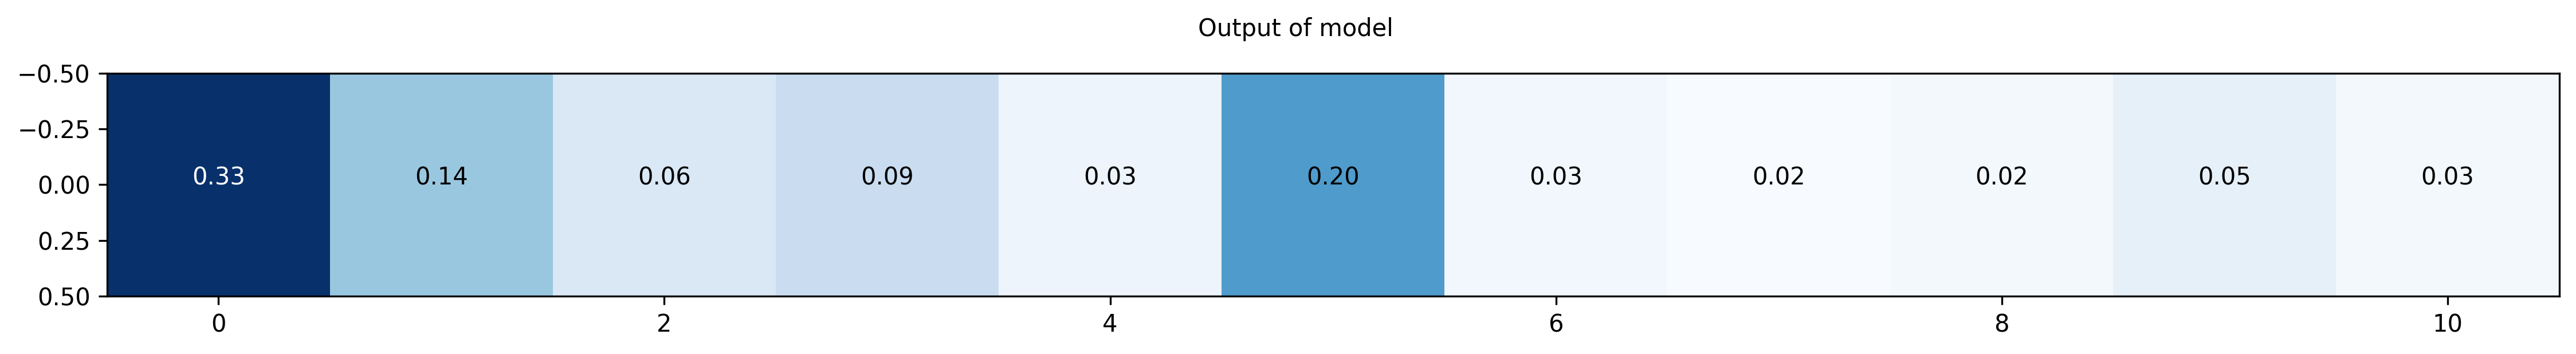

In [15]:
out = model(input_img)
useHeirarchy = params["useHeirarchy"]
if useHeirarchy:
    out = out["species"]

true_example_label = torch.max(out.data, 1)[1].item()
print("True label", true_example_label, dataset.getSpeciesOfIndex(true_example_label))
# PlotNetwork.plot_activations(model, "species", input_img, experimentName,params,  "Output of model", 10)
# sub_model = PlotNetwork.model_activations(model, -1, params["useHeirarchy"])
PlotNetwork.plot_activations(model, -1, input_img, experimentName,params,  "Output of model", 10)

Least confused classes

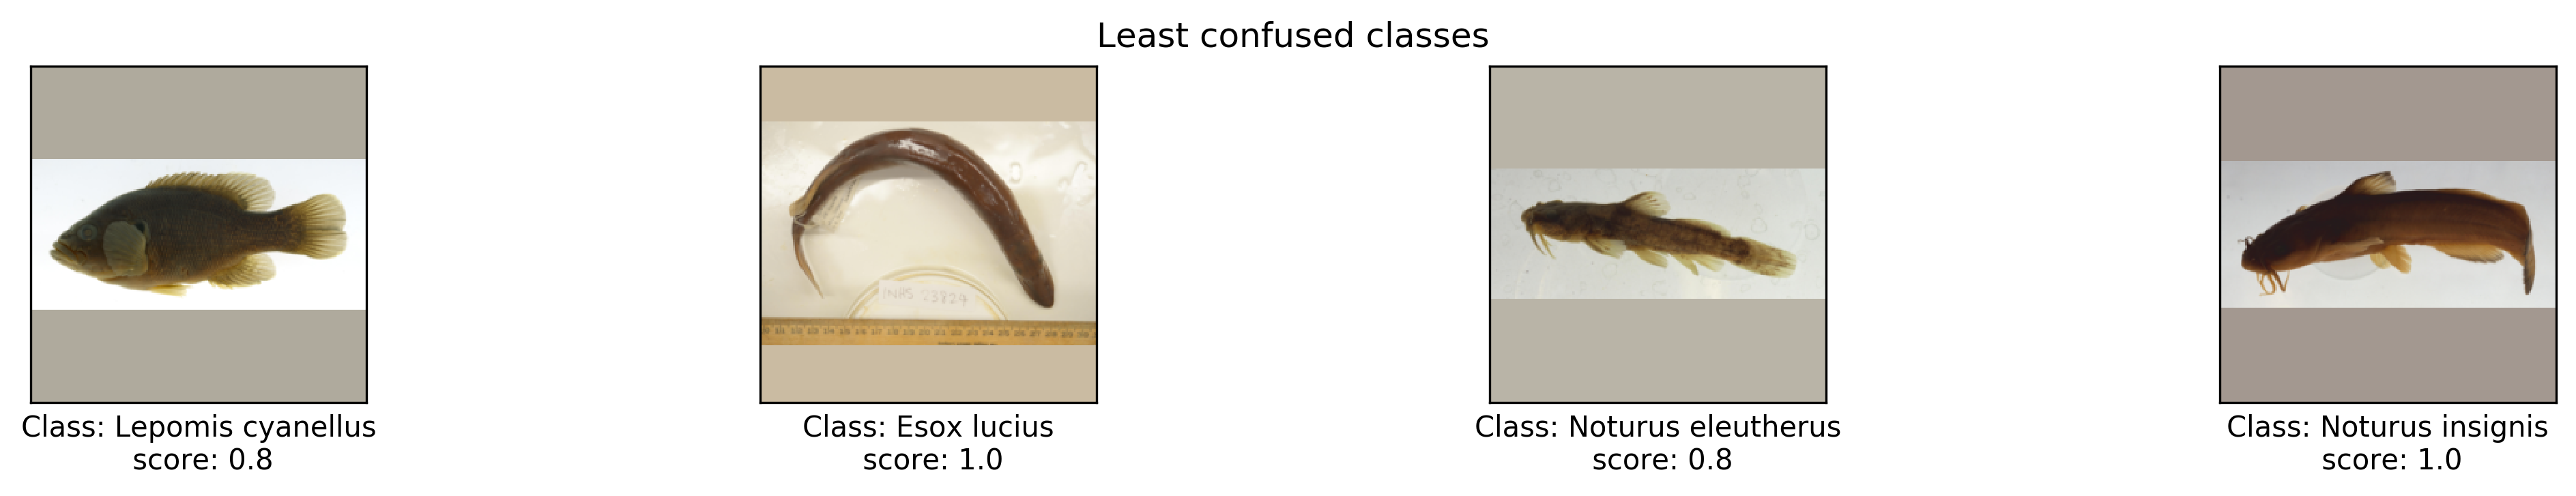

In [16]:
import numpy as np
import math

# From the confusion matrix, find the diagonal entries that have high value.
SuccessThreshold = 0.8

cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
diagIndices = di = np.diag_indices(cm.shape[0])
conf_mat_diagValues = cm[diagIndices]

goodMatches = [i for i,v in enumerate(conf_mat_diagValues) if v >= SuccessThreshold]
goodMatches_count = len(goodMatches)

# Plot
n_channels = params["n_channels"]
number_per_row = 4
n_rows = math.ceil(goodMatches_count/number_per_row)
fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)
out_index = 0
in_index = 0
for i, ax in enumerate(axes.flat):
    if i < goodMatches_count:
        index = goodMatches[i]
        
        speciesExample = dataLoader.getExample(model, dataset, index, index, useHeirarchy)

        if n_channels != 1:
            speciesExample = speciesExample.permute(1, 2, 0)
        ax.set_xlabel("Class: {0}\n score: {1}".format(dataset.getSpeciesOfIndex(index), conf_mat_diagValues[index]))
        ax.imshow(speciesExample.cpu().detach().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        break
        
fig.suptitle("Least confused classes")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()
fig.savefig(os.path.join(experimentName,"LestConfusedClasses.pdf"))
    
    

Most confused classes

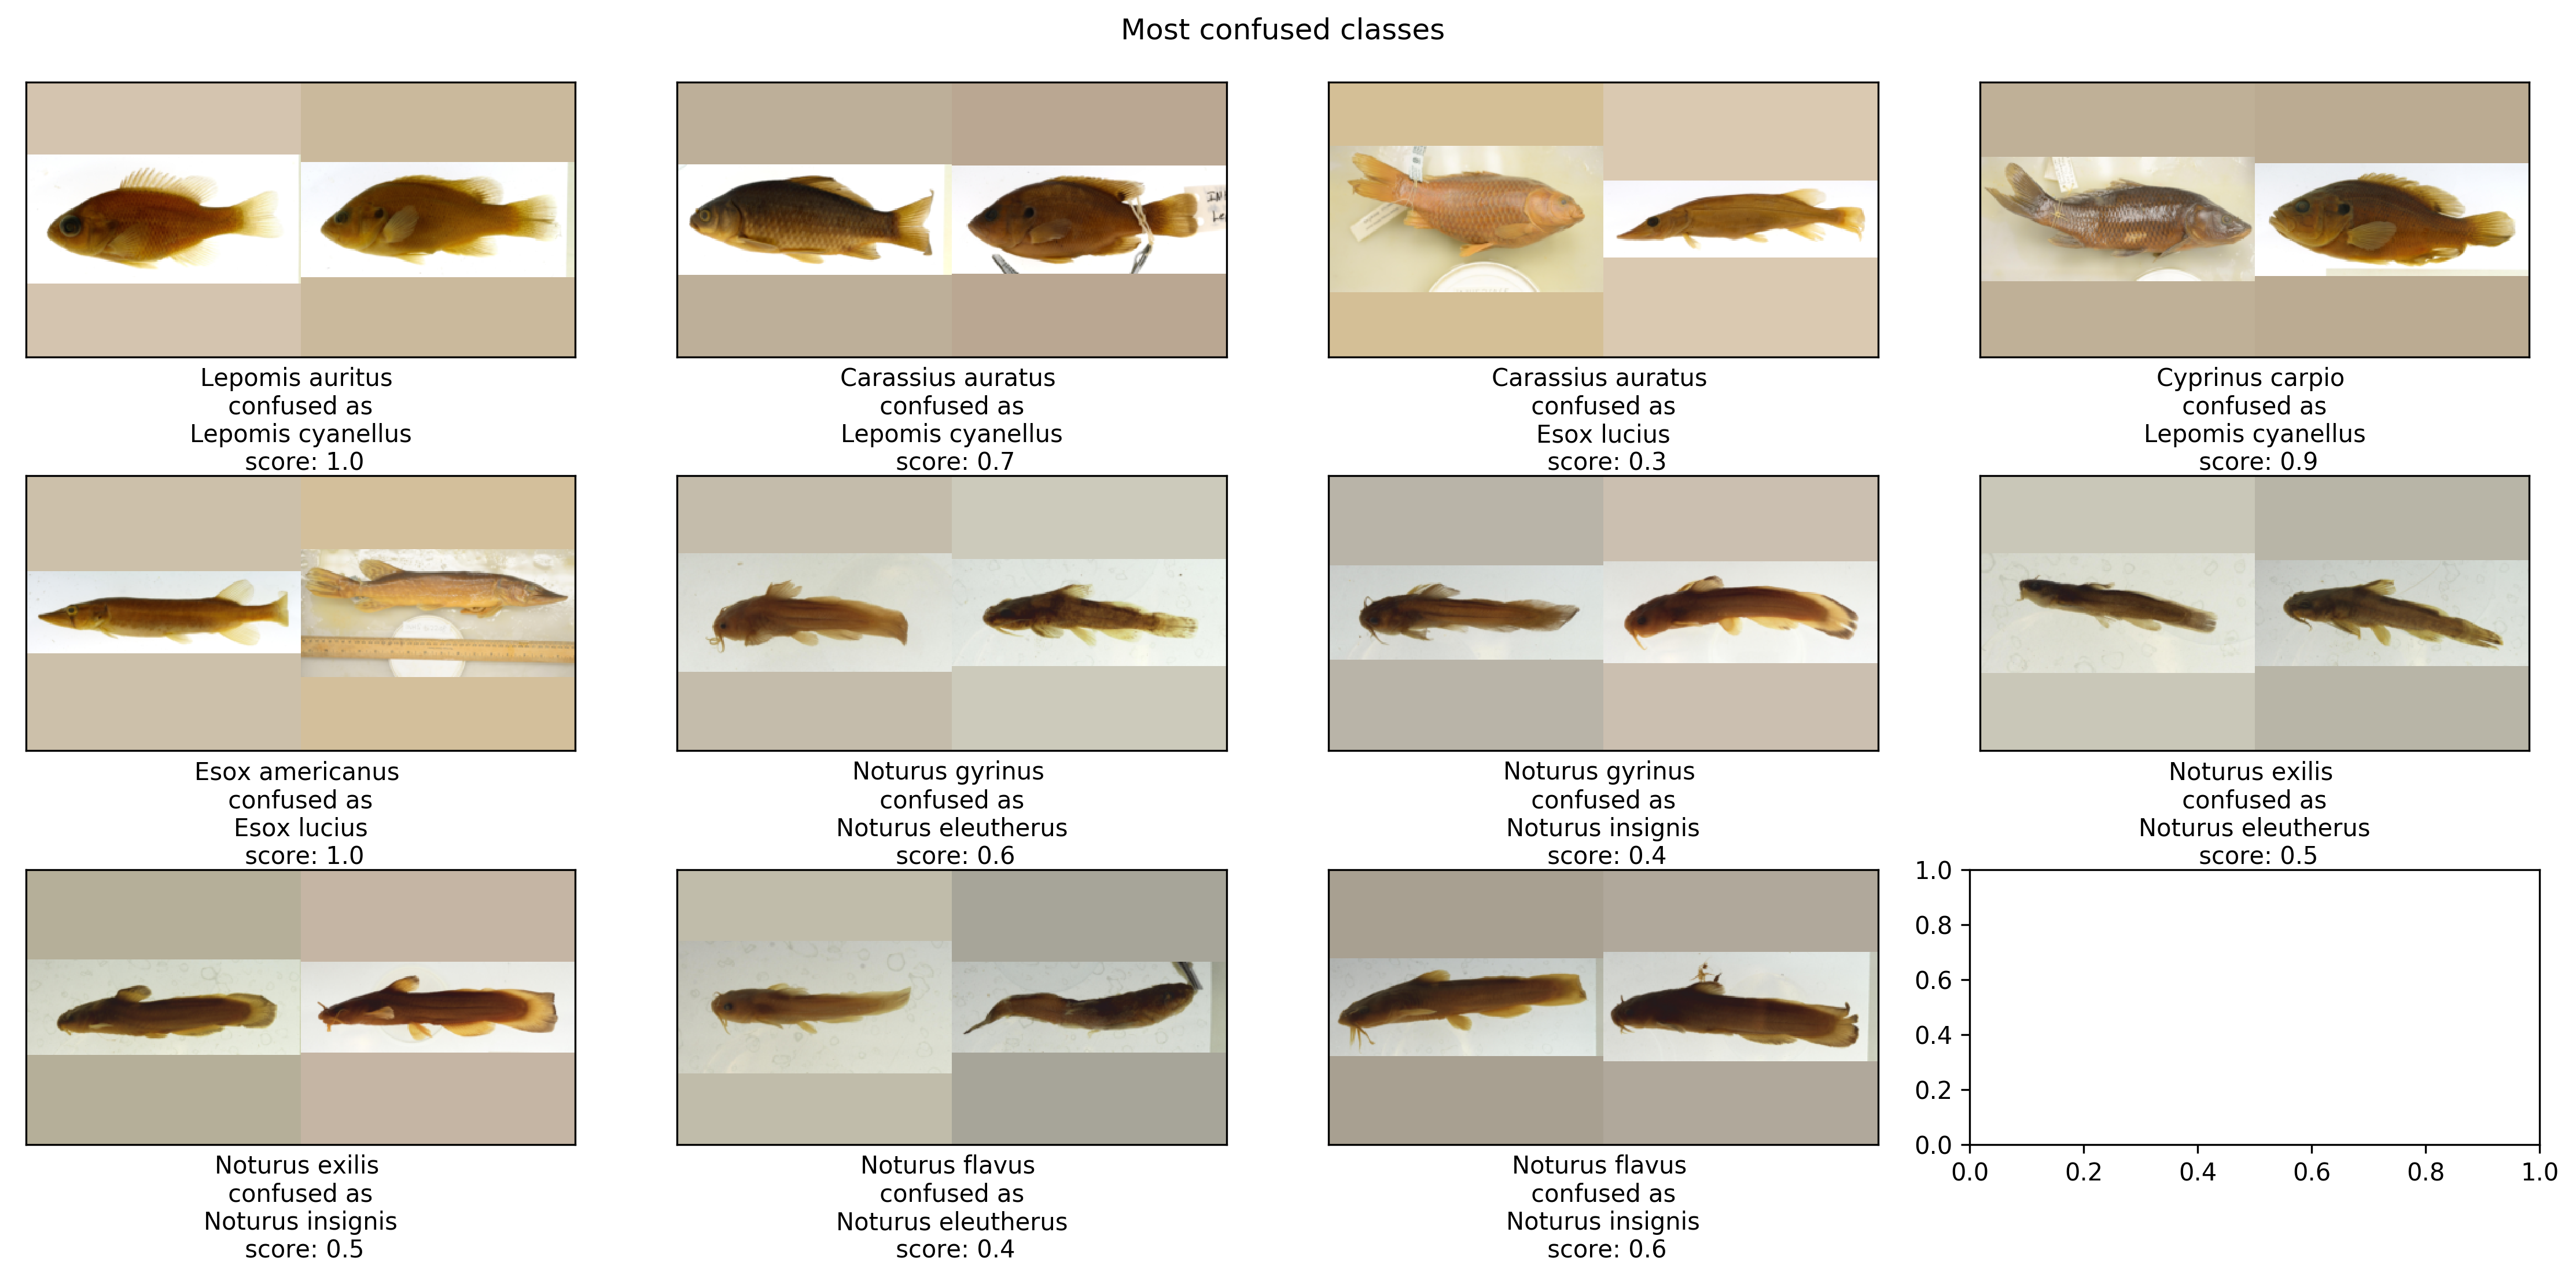

In [17]:
# From the confusion matrix, find the diagonal entries that have high value.
ConfusionThreshold = 0.3

cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
diagIndices = di = np.diag_indices(cm.shape[0])

goodMatches = [(x, y) for (x, y), v in np.ndenumerate(cm) if v >= ConfusionThreshold and x != y]
goodMatches_count = len(goodMatches)

number_per_row = 4
n_rows = math.ceil(goodMatches_count/number_per_row)
if n_rows >0:
    fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)
    out_index = 0
    in_index = 0
    for i, ax in enumerate(axes.flat):
        if i < goodMatches_count:
            (x, y) = goodMatches[i]
            speciesNameConfused = dataset.getSpeciesOfIndex(x)
            speciesNameConfusedAs = dataset.getSpeciesOfIndex(y)
            
            confusedSpeciesExample = dataLoader.getExample(model, dataset, x, y, useHeirarchy)
            confusedAsSpeciesExample = dataLoader.getExample(model, dataset, y, y, useHeirarchy)

            channel = 2 if n_channels != 1 else 1
            stitchedImage = torch.cat((confusedSpeciesExample, confusedAsSpeciesExample), channel)

            if n_channels != 1:
                stitchedImage = stitchedImage.permute(1, 2, 0)
            ax.set_xlabel("{0} \n confused as \n{1}\n score: {2}".format(speciesNameConfused, speciesNameConfusedAs, cm[x][y]))
            ax.imshow(stitchedImage.cpu().detach().numpy())
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            break

    fig.suptitle("Most confused classes")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.show()
    fig.savefig(os.path.join(experimentName,"MostConfusedClasses.pdf"))